In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

from sklearn.multiclass import OneVsRestClassifier


In [14]:


# 📂 Load data
df = pd.read_csv('Equal.csv', encoding='latin-1')

# 🔧 Convert columns to appropriate types
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df['Review'] = df['Review'].astype('string')
df['Summary'] = df['Summary'].astype('string')
df['Sentiment'] = df['Sentiment'].astype('category')

# 🧹 Clean 'Summary' and 'Sentiment' columns
def clean_text_column(column):
    return (
        column
        .str.strip()
        .str.replace('\xa0', '', regex=False)
        .replace(r'^\s*(nan|NaN|NAN)\s*$', np.nan, regex=True)
    )

df['Summary'] = clean_text_column(df['Summary'])
df['Sentiment'] = clean_text_column(df['Sentiment'])


# ❌ Drop rows with missing values in key columns
df.dropna(subset=['Sentiment', 'Review', 'Summary'], inplace=True)

# 🔍 Print data types for verification
print(df.dtypes)

# 🧪 Filter and balance sentiment categories (excluding 'neutral')
df = df[df['Sentiment'] != 'neutral']
df = (
    df.groupby('Sentiment')
    .apply(lambda x: x.sample(n=25000, random_state=42))
    .reset_index(drop=True)
)

# 📊 Display final sentiment distribution
print(df['Sentiment'].value_counts())

product_name             object
product_price            object
Rate                    float64
Review           string[python]
Summary          string[python]
Sentiment                object
dtype: object
Sentiment
negative    25000
positive    25000
Name: count, dtype: int64


C:\Users\Laptop Land\AppData\Local\Temp\ipykernel_11192\3218014260.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=25000, random_state=42))


In [15]:
# معالجة القيم قبل التنظيف
df['Summary'] = df['Summary'].str.strip().str.replace('\xa0', '', regex=False)
df['Summary'] = df['Summary'].replace(r'^\s*(nan|NaN|NAN)\s*$', np.nan, regex=True)

# حذف القيم الفارغة فعليًا
df.dropna(subset=['Summary'], inplace=True)

negation_words = {'no', 'not', 'nor', 'never'}
stop_words = set(stopwords.words('english')) - negation_words
def clean_text(text):
    text = str(text).lower()                             
    text = re.sub(r'[^a-z\s]', '', text)             
    words = text.split()                                 # تقسيم النص لكلمات
    words = [w for w in words if w not in stop_words]    # حذف الكلمات الشائعة
    cleaned = ' '.join(words)
    # if(text=="nan"):
    #    print(f"Original: {text} → Cleaned: {cleaned}")
    return cleaned

df = df.sample(frac=1).reset_index(drop=True)
df['Summary'] = df['Summary'].apply(clean_text)
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce').fillna(0).astype(int)


In [16]:
X = df[['Summary']]
# Explicitly map 'positive' to 1 and 'negative' to 0 for binary classification
y = df['Sentiment'].map({'positive': 1, 'negative': 0})

# Verify the number of classes and some values
print("Value counts for y:")
print(y.value_counts())
print("\nFirst 5 values of y:")
print(y.head())


Value counts for y:
Sentiment
0    25000
1    25000
Name: count, dtype: int64

First 5 values of y:
0    0
1    1
2    0
3    0
4    1
Name: Sentiment, dtype: int64


In [17]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Use 'y' and add stratify
)


In [18]:

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,2)), 'Summary'),
    # ('scaler', StandardScaler())
])


In [19]:

model = Pipeline([
    ('pre', preprocessor),
      ( 'clf',  MultinomialNB())
    # ('clf', DecisionTreeClassifier(max_depth=5, random_state=42)) 
])
# Pipeline([
#     ('pre', preprocessor),
#     ('clf', OneVsRestClassifier( DecisionTreeClassifier(max_depth=5, random_state=42)))
#         # RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)))
# ])



model.fit(X_train, y_train)
y_pred_dt = model.predict(X_test)

sentiment_mapping = {1: 'positive', 0: 'negative'}
y_pred_labels_dt = pd.Series(y_pred_dt).map(sentiment_mapping)
print("Decision Tree Predictions (first 5):")
print(y_pred_labels_dt.head())
print("\nUnique values in Decision Tree predictions:", y_pred_labels_dt.unique())


Decision Tree Predictions (first 5):
0    positive
1    negative
2    positive
3    negative
4    negative
dtype: object

Unique values in Decision Tree predictions: ['positive' 'negative']


In [ ]:


# Sample reviews
my_reviews = [
    "This product is amazing, I highly recommend it!", 
    "I've been using this product for months and I love it!", 
    "I can't believe how great this product is!", 
    "This is a great value for the price, I'm so glad I bought it.", 
    'I received this product as a gift and I absolutely love it!', 
    "I had a great experience using this website to sell my services. It was easy to set up my account and start posting my offers. Highly recommend it!", 
    "This website is a game changer! It helped me find new clients for my services and boosted my business. So grateful for this platform.", 
    "I was hesitant to try this website at first, but I am so glad I did! I was able to find the perfect service provider for my needs and the process was very smooth.", 
    "The interface of this website is very user-friendly and it was easy to navigate through different offers and services. Will definitely use it again!", 
    "I love this website! It has a great variety of services and I always find what I am looking for. It's also very secure and I trust it with my personal information.", 
    "I have been using this website to sell my services for a few months now and it has exceeded my expectations. I have gained many new clients and it has boosted my business significantly.", 
    "I have had a great experience using this website to buy services. The quality of service providers is exceptional and the prices are very reasonable.", 
    "This website is my go-to for all my service needs. I have found amazing providers who offer top-quality services. Highly recommend it!", 
    "I recently started using this website and I am very impressed with the level of customer service. The team is very responsive and helpful.", 
    "I am so glad I found this website! It has made my life so much easier by providing access to reliable and affordable services.", 
    "I was disappointed with the service provider I found on this website. The quality of their work was subpar and it took longer than expected to complete the task.", 
    "The prices for services on this website are too high compared to other platforms. I found a similar service for a much lower price elsewhere.", 
    "I had a difficult time navigating this website and finding what I was looking for. The interface is not very user-friendly.", 
    "I had a negative experience with a service provider on this website. They were unresponsive and did not deliver the promised work on time.", 
    "I was not satisfied with the quality of service I received from a provider on this website. The work was not up to my standards and I had to find someone else to redo it.", 
    "I had issues with payment processing on this website. It was a hassle to resolve and delayed the completion of the service I needed.", 
    "I found the customer service to be unhelpful when I had an issue with a service provider on this website. They did not provide any assistance in resolving the problem.", 
    "I was disappointed to find that the service I needed was not available on this website. It limited my options and I had to look elsewhere.", 
    "The reviews for service providers on this website were not accurate in my experience. I had a different experience than what was described in the reviews.", 
    "I encountered technical issues while using this website, which made it difficult to complete my transaction. It was frustrating and time-consuming to resolve.", 
    "I had a negative experience with a customer service representative on this website. They were unprofessional and did not provide adequate assistance.", 
    "The fees for using this website are too high compared to other platforms. It makes it difficult for service providers to offer competitive prices.", 
    "I had a difficult time communicating with a service provider on this website. They were unresponsive and it delayed the completion of the task." 
]

# Prepare data for prediction
data = {
    'Summary': [review for review in my_reviews]
}

# Create DataFrame from reviews
new_data = pd.DataFrame(data)


# Make predictions
predictions = model.predict(new_data)

# Print predictions
print(predictions)


[0]


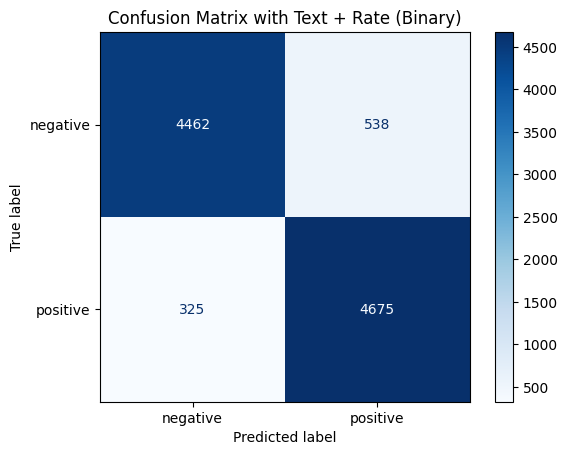

Confusion Matrix:
[[4462  538]
 [ 325 4675]]


In [21]:
# Ensure y_test is a 1D array (this line was already in the previous full code block)
y_true_binary = y_test.flatten() if y_test.ndim > 1 else y_test

# Use the numerical predictions (y_pred_dt) directly for the confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_dt, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Text + Rate (Binary)")
plt.show()
print("Confusion Matrix:")
print(cm)

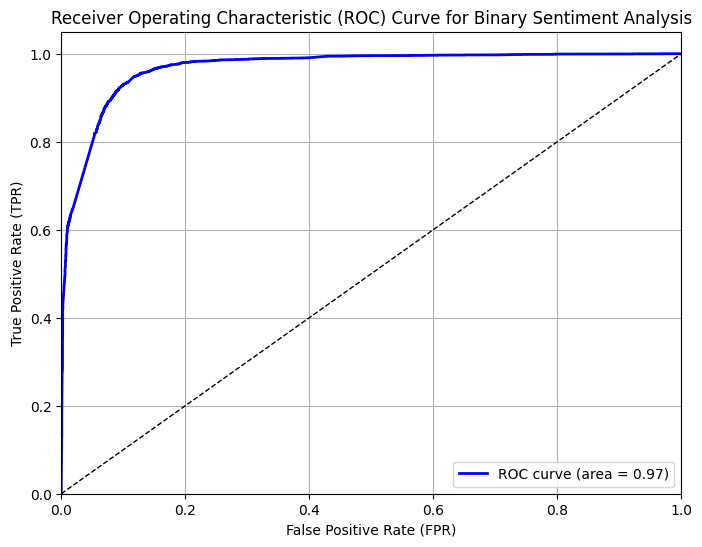

Area Under the Curve (AUC): 0.97


In [22]:

# Ensure y_test is a 1D array (as defined in previous steps)
y_true_binary = y_test.flatten() if y_test.ndim > 1 else y_test

# Get the probability scores for the positive class (class 1) from the Decision Tree model
# model_dt.predict_proba(X_test) returns probabilities for [negative class, positive class]
y_proba_dt = model.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_true_binary, y_proba_dt)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

# Plot the ROC curve for the positive class
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f"ROC curve (area = {roc_auc:.2f})") # Changed label for binary classification

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve for Binary Sentiment Analysis") # Updated title
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Area Under the Curve (AUC): {roc_auc:.2f}")

In [23]:

# Your preprocessor definition
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1,2)), 'Summary'),
    # ('scaler', MinMaxScaler(), ['Rate'])
])

# Define your models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    "Naïve Bayes": MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# Loop through each model for training and evaluation
for name, clf in models.items():
    # Create a pipeline without OneVsRestClassifier for binary classification
    model = Pipeline([
        ('pre', preprocessor),
        ('clf', clf) # Directly use the classifier for binary
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # y_pred will now be 0s and 1s directly

    # Append results using numerical y_test and y_pred
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    # For binary classification, 'weighted' average is often robust
    results["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
    results["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
    results["F1-score"].append(f1_score(y_test, y_pred, average='weighted'))

results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  Precision  Recall  F1-score
0  Random Forest    0.8711   0.871112  0.8711  0.871099
1    Naïve Bayes    0.9137   0.914452  0.9137  0.913661
2  Decision Tree    0.8071   0.811975  0.8071  0.806344


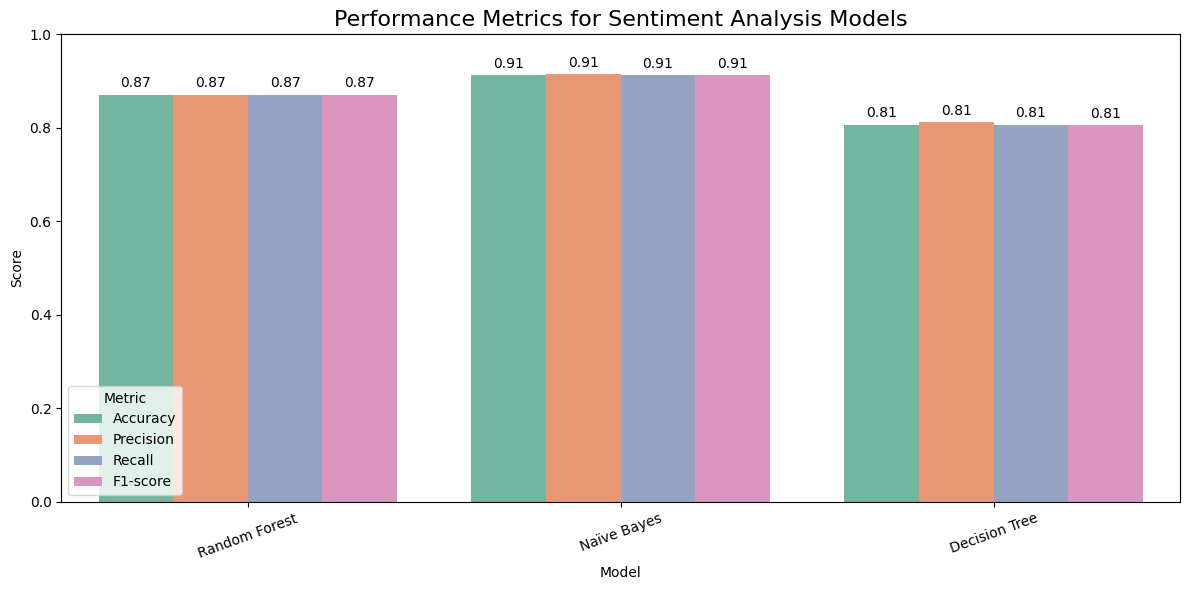

In [24]:
# تحويل النتائج إلى شكل Long Format
results_long = pd.melt(results_df, id_vars=["Model"], 
                       value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                       var_name="Metric", value_name="Score")

# رسم المخطط الموحد
plt.figure(figsize=(12, 6))
sns.barplot(data=results_long, x="Model", y="Score", hue="Metric", palette="Set2")

# تحسين العرض
plt.title("Performance Metrics for Sentiment Analysis Models", fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=20)

# عرض القيم على الأعمدة
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.legend(title="Metric")
plt.tight_layout()
plt.show()